In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch import nn, optim
%matplotlib inline
from DLmodel.rnn import RMSELoss, LSTM
from DLmodel.Transformer import Transformer
from sklearn.preprocessing import MinMaxScaler

In [2]:
torch.cuda.empty_cache()

In [3]:
df = pd.read_csv(
    "./result/congestionlength_for_hours.csv", 
    sep="\t", 
    encoding="unicode_escape",
    index_col=0 
)

In [4]:
scaler = MinMaxScaler()
scaler.fit(df)
scaler.transform(df)
df_std = pd.DataFrame(scaler.transform(df), columns=df.columns)
datetime = df_std.index.values.tolist()
all_congestionlength = df_std.T.values
all_congestionlength = all_congestionlength.reshape(-1, all_congestionlength.shape[1], 1)
congestion_density = dict()
for i in range(len(all_congestionlength)):
    congestionlength = all_congestionlength[i]
    mask = congestionlength > 0 
    congestion_density[i] = congestionlength[mask].sum() / (366 * 24)
    
congestion_density = sorted(congestion_density.items(), key=lambda x: x[1], reverse=True)

d_input = 1
d_output = 1
d_model = 512
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0.1
model = Transformer(num_encoder_layers=num_encoder_layers,
                    num_decoder_layers=num_decoder_layers,
                    d_model=d_model,
                    d_input=d_input, 
                    d_output=d_output,
                    dim_feedforward=dim_feedforward,
                    dropout=dropout, nhead=nhead
                   )
batch_size = 64
loss_fnc = RMSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001) 
optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001)
loss_record = [] 
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")  
epochs = 1000
model.to(device)
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
def sliding_windows(data, seq_length, labels_length):
    x = []
    y = []
    for i in range(len(data)-(seq_length+labels_length)):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+labels_length)]
        x.append(_x)
        y.append(_y)

    return x, y

In [8]:
def create_mask(src, tgt):
    
    seq_len_src = src.shape[1]
    seq_len_tgt = tgt.shape[1]

    mask_tgt = generate_square_subsequent_mask(seq_len_tgt).to(device)
    mask_src = generate_square_subsequent_mask(seq_len_src).to(device)

    return mask_src, mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
    return mask

In [12]:
# for i in range(epochs+1):
#     output_list = []
#     labels_list = []
#     model.train()
#     total_loss = []
#     for idx, temp in enumerate(train_loader):
#         src = temp[0]
#         tgt = temp[1]
#         src = src.float().to(device)
#         tgt = tgt.float().to(device)
#         print(len(src[:,-1:,:]))
#         # print(tgt[:,:-1,:])
#         input_tgt = torch.cat((src[:,-1:,:], tgt[:,:-1,:]), dim=1)
#         mask_src, mask_tgt = create_mask(src, input_tgt)
#         labels_list.append(tgt.to('cpu').detach())
#         output = model(
#             src=src, tgt=input_tgt, 
#             mask_src=mask_src, mask_tgt=mask_tgt
#         )
#         output_list.append(output.to('cpu').detach())
#         optimizer.zero_grad()
#         loss = loss_fnc(output, tgt)
#         loss.backward()
#         total_loss.append(loss.cpu().detach())
#         optimizer.step()
#     if i%100 == 0:
#         print('Epoch:', i, 'Loss_Train:', np.average(total_loss))
#         src_init = list(input_data[0].reshape(-1)) 
#         predicted_train_plot = []
#         model.eval()




In [13]:
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    for src, tgt in data_provider:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        input_tgt = torch.cat((src[:,-1:,:],tgt[:,:-1,:]), dim=1)

        mask_src, mask_tgt = create_mask(src, input_tgt)

        output = model(
            src=src, tgt=input_tgt, 
            mask_src=mask_src, mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        loss = criterion(output, tgt)
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
        
    return np.average(total_loss)


def evaluate(model, data_provider, criterion):
    model.eval()
    total_loss = []
    output_list = []
    for src, tgt in data_provider:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        seq_len_src = src.shape[1]
        mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
        mask_src = mask_src.float().to(device)
        memory = model.encode(src, mask_src)
        outputs = src[:, -1:, :]
        seq_len_tgt = tgt.shape[1]
    
        for i in range(seq_len_tgt - 1):
            mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)
        
            output = model.decode(outputs, memory, mask_tgt)
            output = model.output(output)
            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
        output_list.append(outputs.cpu().detach())
        loss = criterion(outputs, tgt)
        total_loss.append(loss.cpu().detach())    
    return np.average(total_loss), output_list

In [14]:
pred_dict = {}
for idx, _ in congestion_density:
    split_size = int(len(congestionlength) * 0.8)
    train_data = congestionlength[:split_size]
    test_data = congestionlength[split_size:]

    seq_length = 24
    labels_length = 24
    train_X, train_y = sliding_windows(train_data, seq_length, labels_length)
    valid_X, valid_y = sliding_windows(test_data, seq_length, labels_length)
    trainx = torch.tensor(train_X, dtype=torch.float) 
    trainy = torch.tensor(train_y, dtype=torch.float) 
    dataset = torch.utils.data.TensorDataset(trainx, trainy) 
    train_loader = DataLoader(dataset, batch_size=64)
    for i in range(epochs+1):
        result = list()
        total_loss = train(model, train_loader, optimizer, loss_fnc)
        if i%100 == 0:
            total_loss, output_list = evaluate(model, train_loader, loss_fnc)
            print('Epoch:', i, 'Loss_Train:', total_loss)
        for output in output_list[:-1]:
            result += [output[i][0].item() for i in range(len(output))]
        result += [output_list[-1][i][0].item() for i in range(len(output_list[-1])-1)] + list(output_list[-1][-1].flatten().numpy())
    pred_dict[df.columns.values[idx]] = result
    print(pred_dict)
pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv("pred_result.csv")

Epoch: 0 Loss_Train: 0.624951
Epoch: 100 Loss_Train: 0.28288662
Epoch: 200 Loss_Train: 0.31637612
Epoch: 300 Loss_Train: 0.2953091
Epoch: 400 Loss_Train: 0.31437948
Epoch: 500 Loss_Train: 0.3147447


109

In [ ]:
result = list()
true_val = list()
# result = list(output_list[0][0].flatten().numpy()) + [output[0][i][-1].item() for i in range(1, 17)]
# result
for output in output_list[:-1]:
    result += [output[i][0].item() for i in range(len(output))]
result += [output_list[-1][i][0].item() for i in range(len(output_list[-1])-1)] + list(output_list[-1][-1].flatten().numpy())
# for labels in labels_list[:-1]:
#     true_val += [labels[i][0].item() fore i in range(len(labels))]
# true_val += [labels_list[-1][i][0].item() for i in range(len(labels_list[-1])-1)] + list(labels_list[-1][-1].flatten().numpy())

7002


In [ ]:
y_list = list()
for i in range(len(trainx[:-1])):
    y_list.append(list(trainx[i].flatten())[0])
y_list += list(trainx[-1].flatten())
print(len(y_list))

6978


7002


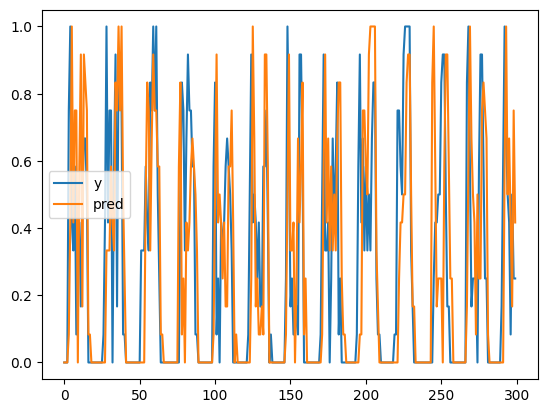

In [ ]:
plt.plot(range(len(y_list[76:376])), y_list[76:376], label='y')
plt.plot(range(len(result[76:376])), result[76:376], label='pred')
print(len(result))
plt.legend()
plt.show()

6978


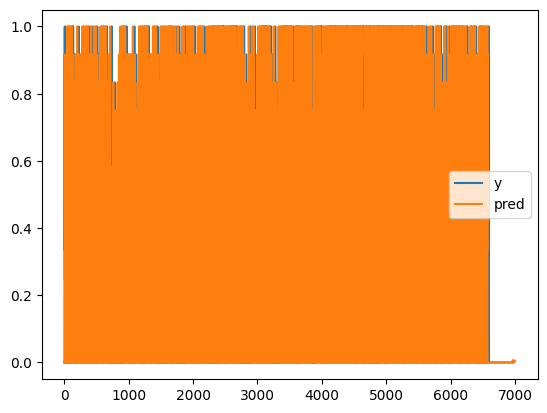

In [ ]:
# y_list = outputs.cpu().detach()[1]
print(len(y_list))
plt.plot(range(len(y_list)), y_list, label='y')
plt.plot(range(len(result)), result, label='pred')
plt.legend()
plt.show()